Gen 0: best penalty=0.0000, best cost=18.10
Gen 10: best penalty=0.0000, best cost=3.50
Gen 20: best penalty=0.0000, best cost=0.60
Gen 30: best penalty=0.0000, best cost=0.00
Gen 40: best penalty=0.0000, best cost=0.00


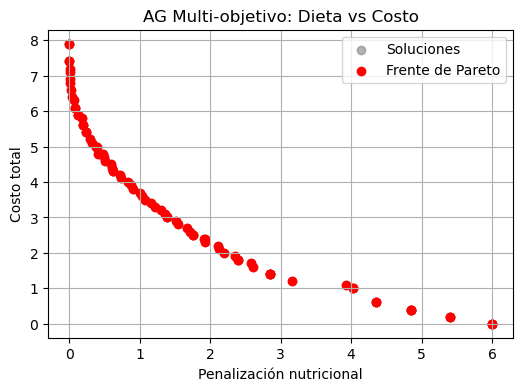


MEJOR DIETA FACTIBLE (costo mínimo):
Porciones: [ 5  0  0  2  6 10  0  0  0  0]
Costo: 7.8999999999999995
Totales nutricionales: {'kcal': np.int32(2420), 'protein': np.int32(114), 'fat': np.int32(71), 'carbs': np.int32(342), 'calcium': np.int32(1020), 'iron': np.int32(21)}


In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

# ============================================================
# DATOS DEL PROBLEMA
# ============================================================

foods = pd.DataFrame([
    {"food":"Arroz",    "cost":0.5, "kcal":200, "protein":4,  "fat":1,  "carbs":44, "calcium":10,  "iron":1},
    {"food":"Frijoles", "cost":0.7, "kcal":150, "protein":9,  "fat":1,  "carbs":27, "calcium":50,  "iron":3},
    {"food":"Pollo",    "cost":1.5, "kcal":250, "protein":27, "fat":14, "carbs":0,  "calcium":15,  "iron":1},
    {"food":"Leche",    "cost":0.8, "kcal":120, "protein":8,  "fat":5,  "carbs":11, "calcium":300, "iron":0},
    {"food":"Pan",      "cost":0.3, "kcal":80,  "protein":3,  "fat":1,  "carbs":15, "calcium":20,  "iron":1},
    {"food":"Huevo",    "cost":0.2, "kcal":70,  "protein":6,  "fat":5,  "carbs":1,  "calcium":25,  "iron":1},
    {"food":"Manzana",  "cost":0.4, "kcal":95,  "protein":0,  "fat":0,  "carbs":25, "calcium":10,  "iron":0},
    {"food":"Espinaca", "cost":0.6, "kcal":40,  "protein":5,  "fat":0,  "carbs":7,  "calcium":150, "iron":4},
    {"food":"Pescado",  "cost":2.0, "kcal":220, "protein":22, "fat":12, "carbs":0,  "calcium":30,  "iron":1},
    {"food":"Carne",    "cost":1.8, "kcal":300, "protein":26, "fat":20, "carbs":0,  "calcium":20,  "iron":2}
])

requirements = {
    "kcal":2000,
    "protein":50,
    "fat":70,
    "carbs":310,
    "calcium":1000,
    "iron":18
}

# ============================================================
# FUNCIONES DE EVALUACIÓN
# ============================================================

def nutrition_totals(ind):
    totals = {k:0 for k in requirements}
    for i, row in foods.iterrows():
        for k in requirements:
            totals[k] += ind[i] * row[k]
    return totals

def nutrition_penalty(ind):
    totals = nutrition_totals(ind)
    penalty = 0.0
    for k, req in requirements.items():
        deficit = max(0, req - totals[k])
        penalty += (deficit / req) ** 2
    return penalty

def cost(ind):
    return sum(ind[i] * foods.loc[i, "cost"] for i in range(len(foods)))

def evaluate(ind):
    # Objetivo 1: minimizar penalización nutricional
    # Objetivo 2: minimizar costo
    return np.array([nutrition_penalty(ind), cost(ind)])

# ============================================================
# OPERADORES GENÉTICOS
# ============================================================

def init_population(pop_size, n_vars, max_portions):
    return np.random.randint(0, max_portions + 1, size=(pop_size, n_vars))

def crossover(p1, p2):
    mask = np.random.rand(len(p1)) < 0.5
    return np.where(mask, p1, p2), np.where(mask, p2, p1)

def mutate(ind, prob=0.1, max_portions=10):
    for i in range(len(ind)):
        if random.random() < prob:
            ind[i] = np.clip(ind[i] + random.choice([-1, 1]), 0, max_portions)
    return ind

# ============================================================
# NSGA-II (UTILIDADES)
# ============================================================

def dominates(a, b):
    return np.all(a <= b) and np.any(a < b)

def fast_non_dominated_sort(objs):
    S = [[] for _ in range(len(objs))]
    n = [0] * len(objs)
    fronts = [[]]

    for p in range(len(objs)):
        for q in range(len(objs)):
            if dominates(objs[p], objs[q]):
                S[p].append(q)
            elif dominates(objs[q], objs[p]):
                n[p] += 1
        if n[p] == 0:
            fronts[0].append(p)

    i = 0
    while fronts[i]:
        next_front = []
        for p in fronts[i]:
            for q in S[p]:
                n[q] -= 1
                if n[q] == 0:
                    next_front.append(q)
        i += 1
        fronts.append(next_front)

    return fronts[:-1]

def crowding_distance(front, objs):
    distance = np.zeros(len(front))
    for m in range(objs.shape[1]):
        values = objs[front, m]
        order = np.argsort(values)
        distance[order[0]] = distance[order[-1]] = np.inf
        min_v, max_v = values[order[0]], values[order[-1]]
        if max_v > min_v:
            for i in range(1, len(front) - 1):
                distance[order[i]] += (values[order[i + 1]] - values[order[i - 1]]) / (max_v - min_v)
    return distance

# ============================================================
# ALGORITMO PRINCIPAL NSGA-II
# ============================================================

def nsga2(pop_size=80, generations=50, max_portions=10):
    n_vars = len(foods)
    pop = init_population(pop_size, n_vars, max_portions)
    objs = np.array([evaluate(ind) for ind in pop])

    for gen in range(generations):
        offspring = []
        while len(offspring) < pop_size:
            i1, i2 = random.sample(range(pop_size), 2)
            c1, c2 = crossover(pop[i1], pop[i2])
            offspring.append(mutate(c1.copy(), max_portions=max_portions))
            if len(offspring) < pop_size:
                offspring.append(mutate(c2.copy(), max_portions=max_portions))

        offspring = np.array(offspring)
        offspring_objs = np.array([evaluate(ind) for ind in offspring])

        combined = np.vstack([pop, offspring])
        combined_objs = np.vstack([objs, offspring_objs])

        fronts = fast_non_dominated_sort(combined_objs)

        new_pop, new_objs = [], []
        for front in fronts:
            if len(new_pop) + len(front) <= pop_size:
                new_pop.extend(combined[front])
                new_objs.extend(combined_objs[front])
            else:
                dist = crowding_distance(front, combined_objs)
                order = np.argsort(-dist)
                needed = pop_size - len(new_pop)
                selected = [front[i] for i in order[:needed]]
                new_pop.extend(combined[selected])
                new_objs.extend(combined_objs[selected])
                break

        pop = np.array(new_pop)
        objs = np.array(new_objs)

        if gen % 10 == 0:
            print(f"Gen {gen}: best penalty={objs[:,0].min():.4f}, best cost={objs[:,1].min():.2f}")

    pareto_front = fast_non_dominated_sort(objs)[0]
    return pop, objs, pareto_front

# ============================================================
# EJECUCIÓN Y RESULTADOS
# ============================================================

pop, objs, pareto = nsga2()

# Visualización del frente de Pareto
plt.figure(figsize=(6,4))
plt.scatter(objs[:,0], objs[:,1], c="gray", alpha=0.6, label="Soluciones")
plt.scatter(objs[pareto,0], objs[pareto,1], c="red", label="Frente de Pareto")
plt.xlabel("Penalización nutricional")
plt.ylabel("Costo total")
plt.title("AG Multi-objetivo: Dieta vs Costo")
plt.legend()
plt.grid()
plt.show()

# Selección de la mejor dieta factible (penalización ~ 0 y menor costo)
feasible = [i for i in pareto if objs[i,0] < 1e-3]
best = min(feasible, key=lambda i: objs[i,1])

print("\nMEJOR DIETA FACTIBLE (costo mínimo):")
print("Porciones:", pop[best])
print("Costo:", objs[best,1])
print("Totales nutricionales:", nutrition_totals(pop[best]))


En este punto modelé el problema clásico de la dieta como un problema de optimización multi-objetivo, incorporando explícitamente el costo total de los alimentos además del cumplimiento de los requerimientos nutricionales mínimos, lo que permitió analizar el compromiso entre calidad nutricional y economía.

El uso de un algoritmo genético multi-objetivo basado en NSGA-II permitió obtener un frente de Pareto de soluciones no dominadas, en lugar de una única dieta, evidenciando que existen múltiples combinaciones de alimentos que satisfacen la dieta con distintos niveles de costo.

La penalización nutricional se empleó como una forma flexible de manejar las restricciones, permitiendo que el algoritmo explore soluciones cercanas a la factibilidad y converja progresivamente hacia dietas que cumplen los requerimientos diarios sin imponer restricciones duras que limiten la diversidad.

Los resultados muestran que es posible identificar dietas con penalización nutricional prácticamente nula y costo mínimo, lo que valida la efectividad del enfoque multi-objetivo frente a métodos de optimización de un solo objetivo.

La representación del frente de Pareto permitió visualizar claramente el trade-off entre costo y cumplimiento nutricional, facilitando la selección informada de una dieta según criterios económicos sin sacrificar la calidad nutricional.

Se observó que la diversidad mantenida por el mecanismo de crowding distance evita la convergencia prematura y garantiza soluciones variadas, lo cual es especialmente relevante en problemas reales donde no existe una única solución óptima.

Como limitación, el modelo depende de la calidad de los datos nutricionales y de costos, así como de los parámetros del algoritmo (tamaño de población, número de generaciones y tasa de mutación). Ajustes en estos parámetros pueden mejorar la convergencia y la estabilidad de los resultados.

En conclusión, el enfoque propuesto demuestra que los algoritmos genéticos multi-objetivo son una herramienta adecuada y flexible para resolver problemas reales de planificación de dietas, donde múltiples criterios deben optimizarse simultáneamente, ofreciendo soluciones interpretables y adaptables a diferentes necesidades.